# Duplicate Bot Tweets

Import our libraries needed for the data handling.

In [1]:
import pandas as pd
import numpy as np
import json
import glob

In [2]:
#Set PANDAS to show all columns in DataFrame
pd.set_option('display.max_columns', None)
# and increase the max number of rows we can show
pd.set_option('display.max_rows', 100)

Libraries for stupid text encoding

In [3]:
from urllib2 import quote
# Unicode strings
from __future__ import unicode_literals

Import libraries needed for visualization.

In [4]:
import matplotlib
import matplotlib.pyplot as plt
# Within notebook viewing
%matplotlib inline

print (matplotlib.__version__)

1.5.3


In [5]:
# Import for axes, color, etc
from pylab import *

Natural Language Processing

In [6]:
%run twokenize.py
import nltk

### Directories

In [7]:
testDir = '../../data/external/trump-bots/'
botDir = '../../data/external/botresults/'
outDir = '../../data/processed/bot-tweets/'

Read in the data files by combining the extracted files.

In [8]:
# Crudely combine
process = []
for f in glob.glob((botDir + "*.txt")):
    with open(f, "rb") as infile:
        for line in infile:
            process.append(json.loads(line))
raw = pd.DataFrame.from_records(process)

del process

print (raw.shape)

(77722, 33)


##### Helper functions

In [9]:
def tknz(text):
    tokens = tokenizeRawTweetText(text)
    filt = [x for x in tokens if not (x.startswith('RT') 
                                   or x.startswith('@') or x.startswith(':') 
                                   or x.startswith('http://') or x.startswith('https://') 
                                  or x.startswith('-') or x.startswith('and') 
                                    or x.startswith('.') or x.startswith(',') 
                                     or x.startswith("'") or x == ('' or '"' or 'a'))]
    return filt

def hsh(tokens):
    # reads a list of tokens
    # tuped = tuple(tokens)
    tuped = ', '.join(tokens)
    hashed = hash(tuped)
    return hashed

In [10]:
def extractInfo(tweet):
    # User variables
    userID = tweet['user']['id_str']
    screenName = tweet['user']['screen_name']
    # Tweet Variables
    text = tweet['text']
    tokens = tknz(text)
    hashed = hsh(tokens)
    retweet = 1 if (type(tweet['retweeted_status']) == dict) else 0
    
    timestamp = tweet['timestamp_ms']
    
    return {'userID':userID, 'screenName':screenName, 'timestamp':timestamp, \
            'text':text, 'tokens':tokens, 'hash':hashed, 'retweet':retweet}
    
    #### below is a horrible rendition of network variables
    
"""
# RT, reply, quoting, or none?
    try:
        if (tweet['retweeted_status'] == True):
            method = 'retweet'
            otherID = tweet['retweeted_status']['user']['id_str']

        if (type(tweet['in_reply_to_user_id_str']) != np.float64):
            method = 'replyUser'
            otherID = tweet['in_reply_to_user_id_str']
        elif (tweet['in_reply_to_status_id_str']):
            method = 'replyStatus'
            otherID = None
        else:
            method = None
            otherID = None

        return {'userID':userID, 'screenName':screenName, 'text':text, 'timestamp':timestamp,
                'method':method, 'otherID':otherID}
    except:
        print tweet
"""

u"\n# RT, reply, quoting, or none?\n    try:\n        if (tweet['retweeted_status'] == True):\n            method = 'retweet'\n            otherID = tweet['retweeted_status']['user']['id_str']\n\n        if (type(tweet['in_reply_to_user_id_str']) != np.float64):\n            method = 'replyUser'\n            otherID = tweet['in_reply_to_user_id_str']\n        elif (tweet['in_reply_to_status_id_str']):\n            method = 'replyStatus'\n            otherID = None\n        else:\n            method = None\n            otherID = None\n\n        return {'userID':userID, 'screenName':screenName, 'text':text, 'timestamp':timestamp,\n                'method':method, 'otherID':otherID}\n    except:\n        print tweet\n"

In [11]:
extracted = pd.DataFrame.from_records(raw.apply(lambda x: extractInfo(x), axis=1))

# throw out the tweets we can't classify
extracted = extracted[extracted['hash'] != 0]

# Calc variables
extracted['timestamp'] = pd.to_datetime(extracted['timestamp'], unit='ms')
extracted['token_str'] = extracted['tokens'].apply(lambda x: ', '.join(x))

extracted.head()

,hash,retweet,screenName,text,timestamp,tokens,userID,token_str
0,8401775961062800512,1,Scrufey21,RT @robinleeclark: Hillary is a murderer and a...,2015-07-06 00:12:43.046,"[Hillary, is, a, murderer, a, traitor, that's,...",490179072,"Hillary, is, a, murderer, a, traitor, that's, ..."
1,-7017692310915600254,1,Scrufey21,RT @PatriotMash: Clinton uses two aides and a ...,2015-07-06 00:17:23.293,"[Clinton, uses, two, aides, a, rope, to, lasso...",490179072,"Clinton, uses, two, aides, a, rope, to, lasso,..."
2,4819910249842125834,1,Scrufey21,RT @NoahWehrman: Press prepare for another day...,2015-07-06 00:19:58.259,"[Press, prepare, for, another, day, of, coveri...",490179072,"Press, prepare, for, another, day, of, coverin..."
3,8041086589735528761,0,CyberAnonymous,nytimes: Hillary Clinton reassures gay youth i...,2015-07-06 00:20:15.542,"[nytimes, Hillary, Clinton, reassures, gay, yo...",128334973,"nytimes, Hillary, Clinton, reassures, gay, you..."
4,-4371809372265221000,1,Scrufey21,RT @LessGovMoreFun: Truth be told: https://t....,2015-07-06 00:20:17.984,"[Truth, be, told]",490179072,"Truth, be, told"


In [12]:
# Get most popular 
print ('Most popular tweet hashes.')

popularTweets = extracted['hash'].value_counts()
popularTweets.columns = ['frequency']
print (popularTweets.head(10))

Most popular tweet hashes.
-535364539560055252     1574
-1290198111922655402    1362
 1650226427655343970     807
-5630792624845697664     624
-4102906781732687656     520
 5602520607808939820     484
 3167448423410501280     176
 8100076757054270788     146
-7094954994022569809     142
-324005199201011350      123
Name: hash, dtype: int64


In [ ]:
# do the same to lookup tokens
popularTokens = extracted['token_str'].value_counts()
print ('Most popular tokens')
popularTokens.head()

In [13]:
# start a data frame for each conceptual tweet
hashes = extracted[['tokens', 'token_str', 'hash']].set_index('hash')

hashes.head()

,tokens,token_str
hash,,
8401775961062800512,"[Hillary, is, a, murderer, a, traitor, that's,...","Hillary, is, a, murderer, a, traitor, that's, ..."
-7017692310915600254,"[Clinton, uses, two, aides, a, rope, to, lasso...","Clinton, uses, two, aides, a, rope, to, lasso,..."
4819910249842125834,"[Press, prepare, for, another, day, of, coveri...","Press, prepare, for, another, day, of, coverin..."
8041086589735528761,"[nytimes, Hillary, Clinton, reassures, gay, yo...","nytimes, Hillary, Clinton, reassures, gay, you..."
-4371809372265221000,"[Truth, be, told]","Truth, be, told"


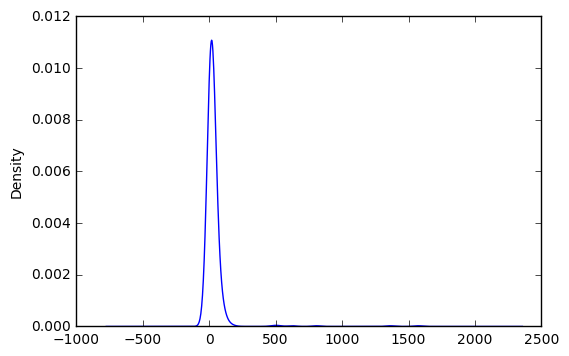

In [16]:
#popularTweets[popularTweets > 1].head(500).plot(kind='bar', xlim=[0, 500], alpha=0.5)
popularTweets[popularTweets > 1].head(500).plot(kind='kde', x=[1,])

In [18]:
mostDiverseTweets = extracted[['userID', 'hash', 'text']].groupby('hash')\
    .agg({'userID': pd.Series.nunique})\
    .sort_values(by='userID', ascending=False)
mostDiverseTweets.columns = ['uniq_users']

# FILTER out singletons
mostDiverseTweets = mostDiverseTweets[mostDiverseTweets['uniq_users'] > 1]
   
print ('Tweets with multiple (unique) users.\n{} statuses with duplicate users'.format(mostDiverseTweets.size))
mostDiverseTweets.head()

Tweets with multiple (unique) users.
50540 statuses with duplicate users


,uniq_users
hash,
-2964838977105228756,50
8100076757054270788,50
-4993197743230146561,48
5748713145738005256,47
7719283613370225873,19


In [20]:
# users
mostProlificUsers = extracted['userID'].value_counts()
mostProlificUsers.columns = ['num_tweets']

mostProlificUsers.head()

3532804813            16989
3920277023             8337
724050768106500096     7697
15195038               4962
490179072              3007
Name: userID, dtype: int64

In [21]:
tweets = extracted[extracted['retweet'] == 0]
retweets = extracted[extracted['retweet'] == 1]

In [22]:
totalObserved = extracted.size
tweetsObserved = tweets.size
retweetsObserved = retweets.size

uniqueObserved = popularTweets[popularTweets['frequency'] > 1]
dupedObserved = totalObserved - uniqueObserved
print ('number of statuses observed: {}\nnumber of *unique* statuses: {}\n...meaning {} tweets/retweets were duplicates sent to people'\
       .format(tweetsObserved, uniqueObserved, dupedObserved))

print ('\n# tweets: {}\n# retweets: {}'.format(tweetsObserved, retweetsObserved))

number of statuses observed: 394128
number of *unique* statuses: 50540
...meaning 566364 tweets/retweets were duplicates sent to people

# tweets: 394128
# retweets: 222776


In [ ]:
# use the value counts to get the hash
hashes['token_str'].value_counts().head(100)

In [30]:
aggregation = {
    'userID': {
        'uniq_users': pd.Series.nunique,
        'users': pd.Series.tolist
    }, 'timestamp': {
        'first_day': 'min',
        'last_day': 'max',
        'time_delta': lambda x: max(x) - min(x)
    }, 'hash': 'count'
}

test = extracted.groupby(['token_str']).agg(aggregation)
test.columns = ['first_day', 'time_delta', 'last_day', 'uniq_users', 'users', 'count']
test.head()

,first_day,time_delta,last_day,uniq_users,users,count
token_str,,,,,,
"!!, John, Pilger, Why, Hillary, Clinton, Is, More, Dangerous, Than, Donald, Trump, #uspoli, #cdnpoli, #newyork, #california, #ohio, ht, …",2016-04-12 22:22:05.879,0 days,2016-04-12 22:22:05.879,1,[3532804813],1
"!, #BAAAAM, Donald, #Trump, Says, Concealed, Carry, Permit, Holders, ‘, Have, an, Obligation, to, Carry, ’, #greta, #Trump2016, #TCOT, ht, …",2015-11-19 13:40:04.912,0 days,2015-11-19 13:40:04.912,1,[3532804813],1
"!, **, Hiss, **, John, Legend, Fires, Shots, At, Donald, Trump, Read, Here",2016-03-26 14:17:06.783,0 days,2016-03-26 14:17:06.783,1,[3532804813],1
"!, ALERT, Romney/Bush, Conspire, to, Murder, #Trump2016, within, two, weeks, !, 3-4-16, &, …",2016-03-08 18:35:45.569,0 days,2016-03-08 18:35:45.569,1,[490179072],1
"!, List, of, people, who, were, pardoned, by, Bill, Clinton, that, committed, actual, crimes, who, then, donated, to, Hillary-RT, !, http, …",2016-05-15 02:54:21.160,0 days,2016-05-15 02:54:21.160,1,[490179072],1


In [34]:
test.sort_values(['count', 'uniq_users'], ascending=False).head(100)

,first_day,time_delta,last_day,uniq_users,users,count
token_str,,,,,,
"Donald, Trump, was, just, mentioned, during, Erin, Burnett, OutFront, on, CNNHD, read, more",2015-10-15 01:18:02.734,121 days 22:38:49.538000,2016-02-13 23:56:52.272,1,"[3920277023, 3920277023, 3920277023, 392027702...",1574
"Dear, #MicroAggression, jump, on, the, #TrumpTrain",2016-04-20 00:16:26.717,33 days 23:16:19.618000,2016-05-23 23:32:46.335,2,"[718859375146708992, 718859375146708992, 71885...",1362
"#RealDonaldTrump, will, save, us",2015-12-18 00:06:25.095,66 days 22:40:32.020000,2016-02-22 22:46:57.115,2,"[4493736743, 4493736743, 4493736743, 449373674...",807
"Donald, Trump, was, just, mentioned, on, FNCHD, #donaldtrump, #trump2016, read, more",2016-04-24 01:01:21.915,6 days 21:44:55.660000,2016-04-30 22:46:17.575,1,"[3920277023, 3920277023, 3920277023, 392027702...",624
"Donald, Trump, was, just, mentioned, on, MSNBC, #donaldtrump, #trump2016, read, more",2016-04-24 14:01:01.746,6 days 04:55:36.987000,2016-04-30 18:56:38.733,1,"[3920277023, 3920277023, 3920277023, 392027702...",520
"Donald, Trump, was, just, mentioned, on, CNNHD, #donaldtrump, #trump2016, read, more",2016-04-24 06:16:35.531,6 days 17:38:43.973000,2016-04-30 23:55:19.504,1,"[3920277023, 3920277023, 3920277023, 392027702...",484
"Donald, Trump, was, just, mentioned, during, The, O'Reilly, Factor, on, FNCHD, read, more",2015-11-19 09:16:28.266,127 days 18:41:02.318000,2016-03-26 03:57:30.584,1,"[3920277023, 3920277023, 3920277023, 392027702...",176
"Check, out, Donald, Trump, Your, President, #Trump2016, #TrumpTrain, by, Rick, Poppe",2016-06-24 00:00:24.979,101 days 23:58:44.633000,2016-10-03 23:59:09.612,50,"[720148170, 1034349768, 1046232786, 2801236378...",146
"Donald, Trump, was, just, mentioned, during, America's, News, Headquarters, on, FNCHD, read, more",2015-12-12 18:11:15.906,106 days 02:43:35.890000,2016-03-27 20:54:51.796,1,"[3920277023, 3920277023, 3920277023, 392027702...",142
